/var/folders/xv/s21tw0zj3njb0tc6nb87t33r0000gn/T/ipykernel_53874/3735518449.py:149: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(right=0.8)


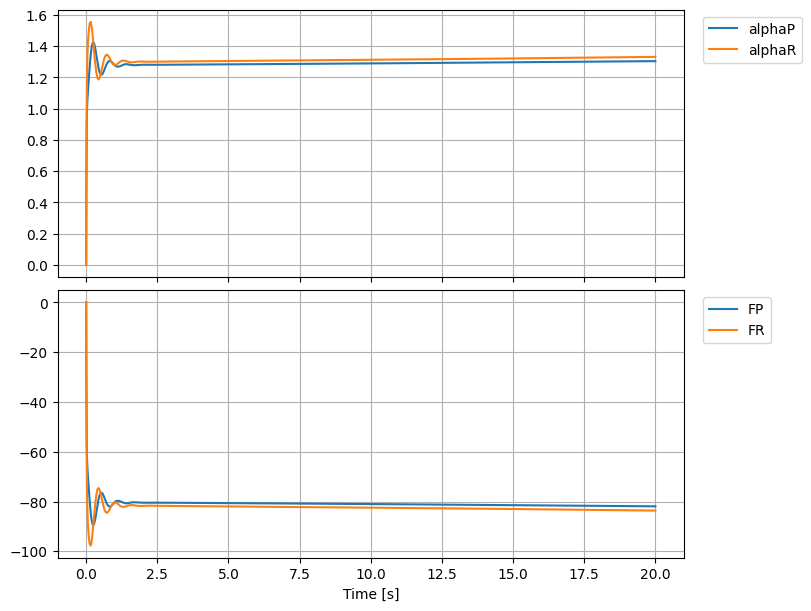

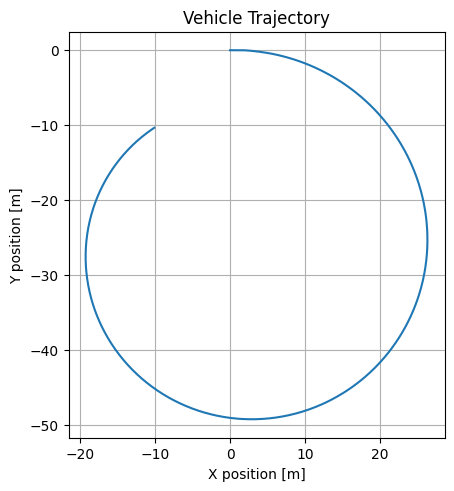

In [84]:
import numpy as np
import sympy as sm
import sympy.physics.mechanics as me
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# %%
# Specify the equations of motion
# -------------------------------
#
# The model is constructed using several constant parameters:
#
# - :math:`h`: distance mass center is from the ground contact line
# - :math:`a`: longitudinal distance of the mass center from the rear contact
# - :math:`b`: wheelbase length
# - :math:`g`: acceleration due to gravity
# - :math:`m`: mass of bicycle and rider
# - :math:`I_1`: roll principle moment of inertia
# - :math:`I_2`: pitch principle moment of inertia
# - :math:`I_3`: yaw principle moment of inertia
h, a, b, g = sm.symbols('h a, b, g', real=True)
m, I1, I2, I3 = sm.symbols('m, I1, I2, I3', real=True)
CaP, CaR = sm.symbols('CaP, CaR', real=True)

q1, q2, q3, q4, q5 = me.dynamicsymbols('q1, q2, q3, q4, q5', real=True)
u1, u2, u3, u4, u5 = me.dynamicsymbols('u1, u2, u3, u4, u5', real=True)
t = me.dynamicsymbols._t

q = sm.Matrix([q1, q2, q3, q4])
u = sm.Matrix([u1, u2, u3, u4])
p = sm.Matrix([h, a, b, g, m, I1, I2, I3, CaP, CaR])
r = sm.Matrix([q5, u5])

N, A, B, C = sm.symbols('N, A, B, C', cls=me.ReferenceFrame)
O, P, Q, R, S = sm.symbols('O, P, Q, R, S',  cls=me.Point)

A.orient_axis(N, q3, N.z)
B.orient_axis(A, q4, A.x)
C.orient_axis(A, q5, A.z)

P.set_pos(O, q1*N.x + q2*N.y)
Q.set_pos(P, a*A.x)
R.set_pos(P, b*A.x)
S.set_pos(Q, h*B.z)

A.set_ang_vel(N, u3*N.z)
B.set_ang_vel(A, u4*A.x)
C.set_ang_vel(A, u5*A.z)

O.set_vel(N, 0)
P.set_vel(N, u1*N.x + u2*N.y)
Q.v2pt_theory(P, N, A)
R.v2pt_theory(P, N, A)
S.v2pt_theory(Q, N, B)

IB = me.Inertia.from_inertia_scalars(S, B, I1, I2, I3)

bike_body = me.RigidBody('bike', S, B, m, IB)

alphaP = sm.atan(P.vel(N).dot(A.y) / P.vel(N).dot(A.x))
alphaR = sm.atan(R.vel(N).dot(C.y) / R.vel(N).dot(C.x))

gravity = me.Force(S, -m*g*N.z)
rear_tire = me.Force(P, -CaP*alphaP*A.y)
front_tire = me.Force(R, -CaR*alphaR*C.y)

kane = me.KanesMethod(
    N,
    (q1, q2, q3, q4),
    (u1, u2, u3, u4),
    kd_eqs=(u1 - q1.diff(t),
            u2 - q2.diff(t),
            u3 - q3.diff(t),
            u4 - q4.diff(t),)
)

kane.kanes_equations(bodies=(bike_body,),
                     loads=(gravity, front_tire, rear_tire))

eval_eom = sm.lambdify((q, u, r, p),
                       (kane.mass_matrix_full, kane.forcing_full))

eval_slip = sm.lambdify((q, u, r, p), (alphaP, alphaR))

target_roll_angle = np.deg2rad(10.0)
initial_speed = 7.0  # m/s


def control(t, q, u):
    gain = 3.0
    return np.array([gain*(target_roll_angle - q[3]), -gain*u[3]])


def rhs(t, x, p):
    q = x[0:4]
    u = x[4:8]
    r = control(t, q, u)
    M, F = eval_eom(q, u, r, p)
    return np.linalg.solve(M, F.squeeze())


x0 = np.array([
    0.0,
    0.0,
    0.0,
    target_roll_angle,  # q4 [rad]
    initial_speed,  # u1 [m/s]
    0.0,
    0.0,
    0.0,
])

p_vals = np.array([
    1.0,  # h [m]
    0.5,  # a [m]
    1.0,  # b [m]
    9.81,  # g [m/s^2]
    87.0,  # m [kg]
    9.2,  # I1 [kg m^2]
    11.0,  # I2 [kg m^2]
    2.8,  # I3 [kg m^2]
    3600.0,  # CaP, Fig 7.4 in Gabriele's thesis shows Ca=(100 N / 2 deg)
    3600.0,  # CaR
])


solution = solve_ivp(rhs, (0.0, 20.0), x0, args=(p_vals,))

qs = solution.y[0:4]
us = solution.y[4:8]
rs = control(solution.t, qs, us)
alphaPs, alphaRs = eval_slip(qs, us, rs, p_vals)


fig, axes = plt.subplots(2, 1, sharex=True, layout='constrained', figsize=(8, 6))

# Plot 4: Slip angles
axes[0].plot(solution.t, np.rad2deg(alphaPs), solution.t, np.rad2deg(alphaRs))
axes[0].legend(['alphaP', 'alphaR'], bbox_to_anchor=(1.02, 1), loc='upper left')
axes[0].grid()

# Plot 5: Tire forces
axes[1].plot(solution.t, -p_vals[-2]*alphaPs, solution.t, -p_vals[-1]*alphaRs)
axes[1].legend(['FP', 'FR'], bbox_to_anchor=(1.02, 1), loc='upper left')
axes[1].grid()
axes[1].set_xlabel('Time [s]')

# Adjust subplot spacing to accommodate legends
plt.subplots_adjust(right=0.8)

# Trajectory plot
fig2, ax = plt.subplots(layout='constrained')
ax.plot(qs[0], qs[1])
ax.set_aspect('equal')
ax.set_xlabel('X position [m]')
ax.set_ylabel('Y position [m]')
ax.set_title('Vehicle Trajectory')
ax.grid(True)

plt.show()

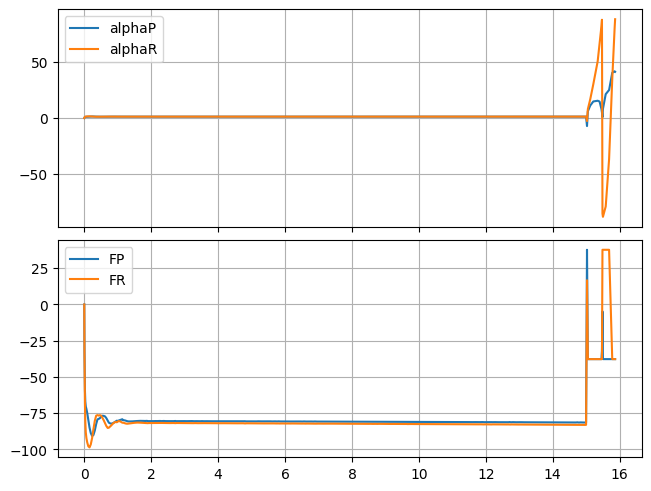

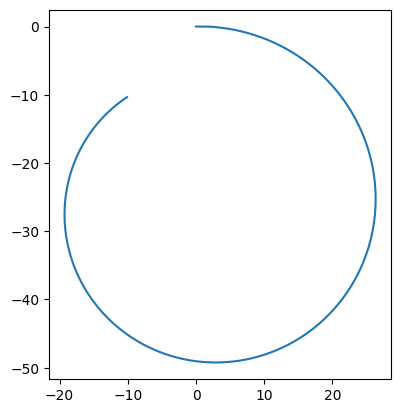

In [85]:
p = sm.Matrix([h, a, b, g, m, I1, I2, I3, ])#CaP, CaR
gravity = me.Force(S, -m*g*N.z)
rear_tire = me.Force(P, -CaP*alphaP*A.y)
front_tire = me.Force(R, -CaR*alphaR*C.y)

kane = me.KanesMethod(
    N,
    (q1, q2, q3, q4),
    (u1, u2, u3, u4),
    kd_eqs=(u1 - q1.diff(t),
            u2 - q2.diff(t),
            u3 - q3.diff(t),
            u4 - q4.diff(t),)
)

kane.kanes_equations(bodies=(bike_body,),
                     loads=(gravity, front_tire, rear_tire))

eval_eom_ice = sm.lambdify((q, u, r, p, CaP, CaR),
                       (kane.mass_matrix_full, kane.forcing_full))

eval_slip_ice = sm.lambdify((q, u, r, p, CaP, CaR), (alphaP, alphaR))

target_roll_angle = np.deg2rad(10.0)
initial_speed = 7.0  # m/s

# Create empty arrays to store slip angles and tire forces
alphaP_history_ice = []
alphaR_history_ice = []
FyP_history_ice = []
FyR_history_ice = []

time_history_ice = []

def control(t, q, u):
    gain = 3.0
    return np.array([gain*(target_roll_angle - q[3]), -gain*u[3]])


def rhs_ice(t, x, p):
    q = x[0:4]
    u = x[4:8]
    r = control(t, q, u)

     # Update CaP and CaR based on time
    if 15 <= t <= 19.0:
        CaP = 360.0  # for car on ice the value is normalized btwn 0.05 and 0.1 from the book on your PPT slide
        CaR = 360.0  # 
    else:
        CaP = 3600.0  # for a car the value is normalized between 0.8 and 1.0
        CaR = 3600.0  # 

 # Evaluate the equations of motion with the updated parameters
    M, F = eval_eom_ice(q, u, r, p, CaP, CaR)

    # Evaluate slip angles
    alphaP_val_ice, alphaR_val_ice = eval_slip_ice(q, u, r, p, CaP, CaR)

    alphaP_history_ice.append(alphaP_val_ice)
    alphaR_history_ice.append(alphaR_val_ice)

    # Cap slip angles at 6 degrees
    alpha_max = np.deg2rad(6.0)
    alphaP_val_ice = np.clip(alphaP_val_ice, -alpha_max, alpha_max)
    alphaR_val_ice = np.clip(alphaR_val_ice, -alpha_max, alpha_max)

    # Calculate tire forces
    time_history_ice.append(t)
    FyP_ice = -CaP * alphaP_val_ice
    FyR_ice = -CaR * alphaR_val_ice
    FyP_history_ice.append(FyP_ice)
    FyR_history_ice.append(FyR_ice)


    return np.linalg.solve(M, F.squeeze())


p_vals = np.array([
    1.0,  # h [m]
    0.5,  # a [m]
    1.0,  # b [m]
    9.81,  # g [m/s^2]
    87.0,  # m [kg]
    9.2,  # I1 [kg m^2]
    11.0,  # I2 [kg m^2]
    2.8,  # I3 [kg m^2]
    # 3600.0,  # CaP, Fig 7.4 in Gabriele's thesis shows Ca=(100 N / 2 deg)
    # 3600.0,  # CaR
])

def roll_angle_event(t, x, p):
    """
    Event function to stop the solver if roll angle (theta) exceeds 60 or goes below -60 degrees.
    """
    roll_angle = np.rad2deg(x[3])  # x[3] is the roll angle (theta), converted to degrees
    max_angle = 90  # Upper and lower bounds in degrees
    
    # Return the difference between the roll angle and the bounds
    # The event is triggered when this value crosses zero
    return roll_angle**2 - max_angle**2  # Returns 0 when |roll_angle| == max_angle

# Set the event properties
roll_angle_event.terminal = True  # Stop the solver when the event is triggered
roll_angle_event.direction = 0    # Detect event when crossing from either direction (positive or negative)

solution_ice = solve_ivp(rhs_ice, (0.0, 20.0), x0, args=(p_vals,),  events=roll_angle_event)

qs_ice = solution_ice.y[0:4]
us_ice = solution_ice.y[4:8]
rs_ice = control(solution_ice.t, qs_ice, us_ice)
alphaPs_ice, alphaRs_ice = eval_slip_ice(qs_ice, us_ice, rs_ice, p_vals, CaP, CaR)
# Convert stored values to numpy arrays
alphaP_arr_ice = np.array(alphaP_history_ice).squeeze()
alphaR_arr_ice = np.array(alphaR_history_ice).squeeze()
FyP_arr_ice = np.array(FyP_history_ice).squeeze()
FyR_arr_ice = np.array(FyR_history_ice).squeeze()

# Create time array for stored values (from the solver's internal steps)
internal_times_ice = np.array(time_history_ice)  # You'll need to store time in rhs()

# Create interpolation functions
from scipy.interpolate import interp1d
interp_alphaP_ice = interp1d(internal_times_ice, alphaP_arr_ice, bounds_error=False, fill_value="extrapolate")
interp_alphaR_ice = interp1d(internal_times_ice, alphaR_arr_ice, bounds_error=False, fill_value="extrapolate")
interp_FyP_ice = interp1d(internal_times_ice, FyP_arr_ice, bounds_error=False, fill_value="extrapolate")
interp_FyR_ice = interp1d(internal_times_ice, FyR_arr_ice, bounds_error=False, fill_value="extrapolate")

# Get values at solution time points
alphaP_plot_ice = interp_alphaP_ice(solution_ice.t)
alphaR_plot_ice = interp_alphaR_ice(solution_ice.t)
FyP_plot_ice = interp_FyP_ice(solution_ice.t)
FyR_plot_ice = interp_FyR_ice(solution_ice.t)

# Now create your plots
fig, axes = plt.subplots(2, 1, sharex=True, layout='constrained')

# Plot slip angles using stored values
axes[0].plot(solution_ice.t, np.rad2deg(alphaP_plot_ice), solution_ice.t, np.rad2deg(alphaR_plot_ice))
axes[0].legend(['alphaP', 'alphaR'])
axes[0].grid()

# Plot tire forces using stored values
axes[1].plot(solution_ice.t, FyP_plot_ice, solution_ice.t, FyR_plot_ice)
axes[1].legend(['FP', 'FR'])
axes[1].grid()


fig, ax = plt.subplots()
ax.plot(qs[0], qs[1])
ax.set_aspect('equal')

/var/folders/xv/s21tw0zj3njb0tc6nb87t33r0000gn/T/ipykernel_53874/1981502926.py:31: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(right=0.8)


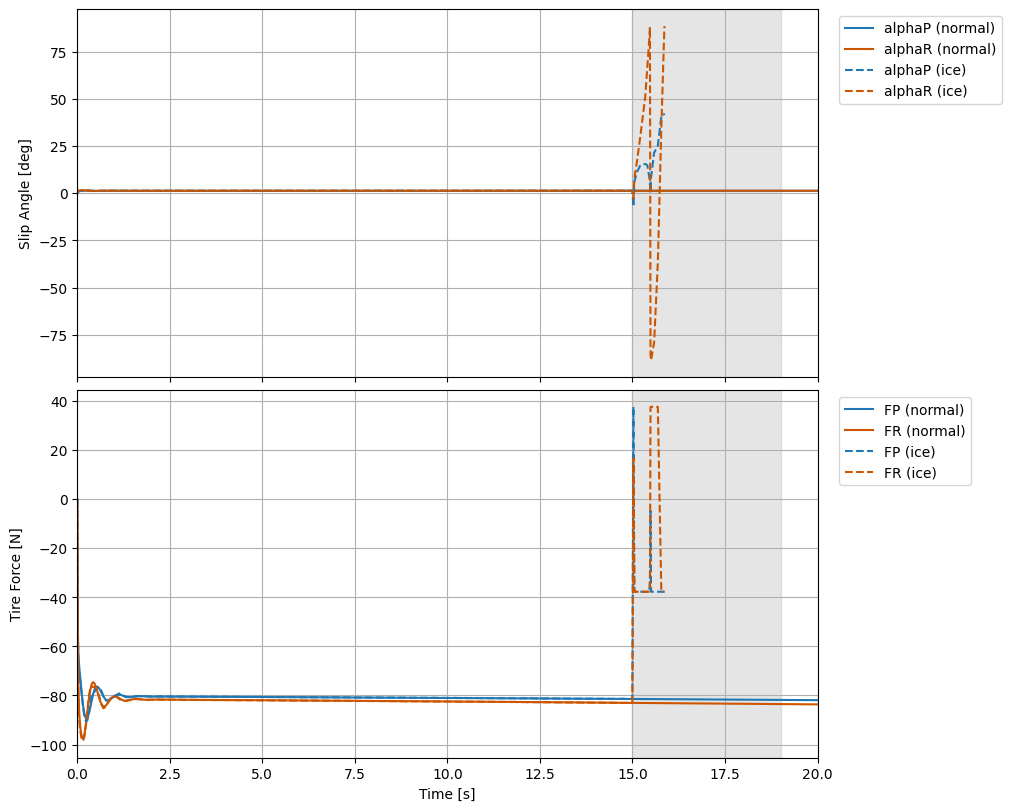

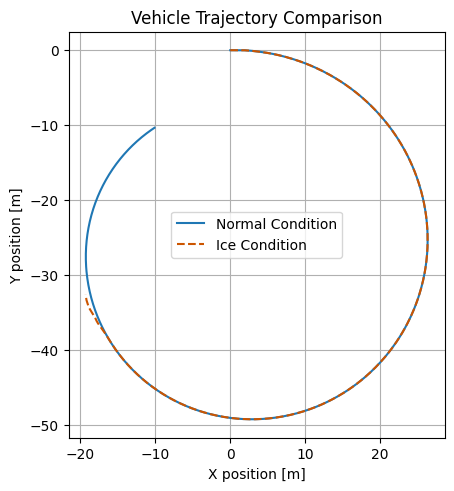

In [86]:
# Define colors
blue = '#1f77b4'  # Standard matplotlib blue
burntorange = '#CC5500'  # Burnt orange color

# Create combined plots
fig, axes = plt.subplots(2, 1, sharex=True, layout='constrained', figsize=(10, 8))

# Plot slip angles comparison
axes[0].plot(solution.t, np.rad2deg(alphaPs), color=blue, linestyle='-', label='alphaP (normal)')
axes[0].plot(solution.t, np.rad2deg(alphaRs), color=burntorange, linestyle='-', label='alphaR (normal)')
axes[0].plot(solution_ice.t, np.rad2deg(alphaP_plot_ice), color=blue, linestyle='--', label='alphaP (ice)')
axes[0].plot(solution_ice.t, np.rad2deg(alphaR_plot_ice), color=burntorange, linestyle='--', label='alphaR (ice)')
axes[0].set_ylabel('Slip Angle [deg]')
axes[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
axes[0].grid()
axes[0].axvspan(15, 19, color='gray', alpha=0.2, label='Ice Condition')
axes[0].set_xlim(0, 20)  # Set x-axis limit to 20

# Plot tire forces comparison
axes[1].plot(solution.t, -3600*alphaPs, color=blue, linestyle='-', label='FP (normal)')
axes[1].plot(solution.t, -3600*alphaRs, color=burntorange, linestyle='-', label='FR (normal)')
axes[1].plot(solution_ice.t, FyP_plot_ice, color=blue, linestyle='--', label='FP (ice)')
axes[1].plot(solution_ice.t, FyR_plot_ice, color=burntorange, linestyle='--', label='FR (ice)')
axes[1].set_ylabel('Tire Force [N]')
axes[1].set_xlabel('Time [s]')
axes[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
axes[1].grid()
axes[1].axvspan(15, 19, color='gray', alpha=0.2)
axes[1].set_xlim(0, 20)  # Set x-axis limit to 20

plt.subplots_adjust(right=0.8)

# Combined trajectory plot
fig2, ax = plt.subplots(layout='constrained')
ax.plot(qs[0], qs[1], color=blue, linestyle='-', label='Normal Condition')
ax.plot(qs_ice[0], qs_ice[1], color=burntorange, linestyle='--', label='Ice Condition')
ax.set_aspect('equal')
ax.set_xlabel('X position [m]')
ax.set_ylabel('Y position [m]')
ax.set_title('Vehicle Trajectory Comparison')
ax.legend()
ax.grid(True)

plt.show()